In [1]:
# 참고: https://www.kaggle.com/code/danielkorth/visualizing-neural-networks-using-t-sne-and-umap/notebook

import os
import multiprocessing

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# import torchvision
# import pandas as pd
import matplotlib.pyplot as plt

from importlib import import_module

# import seaborn as sns


/opt/conda/envs/p1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
use_cuda = torch.cuda.is_available()
# GPU 사용가능하면 True 반환

device = torch.device("cuda" if use_cuda else "cpu")
print(f"==>> device: {device}")

==>> device: cuda


In [3]:
def load_model(saved_model, model_name, num_classes, device):
    """
    저장된 모델의 가중치를 로드하는 함수입니다.

    Args:
        saved_model (str): 모델 가중치가 저장된 디렉토리 경로
        num_classes (int): 모델의 클래수 수
        device (torch.device): 모델이 로드될 장치 (CPU 또는 CUDA)

    Returns:
        model (nn.Module): 가중치가 로드된 모델
    """
    model_cls = getattr(import_module("model"), model_name)
    model = model_cls(num_classes=num_classes)

    # tarpath = os.path.join(saved_model, 'best.tar.gz')
    # tar = tarfile.open(tarpath, 'r:gz')
    # tar.extractall(path=saved_model)

    # 모델 가중치를 로드한다.
    model_path = os.path.join(saved_model, "best.pth")
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # model.load_state_dict(torch.load(model_path, map_location=device))
    # %% torch.save에서 optimizer, scheduler 같이 저장 안한 경우
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    model.load_state_dict(torch.load(model_path)["model_state_dict"])
    model.to(device)

    return model

In [4]:
model_dir = "/data/ephemeral/home/model/MyModel5_1216_1005"
# 불러올 모델 경로 (best.pth가 들어있는 폴더)
data_dir = "/data/ephemeral/home/train/images"
# 사진 경로
model_name = "MyModel5"
# 모델 클래스 이름
dataset_name = "MaskSplitByProfileDataset3"
# 사용할 데이터셋 클래스 이름
aug_name = "CustomAugmentation9"
# 사용할 aug 클래스 이름
resize = [256,192]
# 모델 훈련에 사용한 resize 값과 동일하게 설정
num_classes = 18

In [5]:
model = load_model(model_dir, model_name, num_classes, device).to(device)
# model 불러오기

dataset_module = getattr(import_module("dataset"), dataset_name)  # default: MaskBaseDataset
dataset = dataset_module(
    data_dir=data_dir,
)

transform_module = getattr(import_module("dataset"), aug_name)  # default: BaseAugmentation
transform = transform_module(
    resize=resize,
    mean=dataset.mean,
    std=dataset.std,
)
dataset.set_transform(transform)
# dataset, aug 불러오기


loader = DataLoader(
    dataset,
    batch_size=1000,
    num_workers=multiprocessing.cpu_count() // 2,
    shuffle=False,
    pin_memory=use_cuda,
    drop_last=True,
)
# dataloader 설정

/opt/conda/envs/p1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/p1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def embedding(data):
    """
    시각화 하려는 feature vector 생성 함수
    시각화할 layer output을 여기서 계산 

    Args:
        data (torch.Tensor): 사진 인풋

    Returns:
        torch.Tensor: feature vector 
    """
    model.eval()
    x1 = model.backbone(data)
    x2 = model.backbone2(data)
    x1 = x1.view(data.size(0), -1)
    x2 = x2.view(data.size(0), -1)

    x_mask = model.mask_classifier[:-1](x1)
    x_gender = model.gender_classifier[:-1](x1)
    x_age = model.age_classifier[:-1](x2)
    # ex: 각 classifier의 마지막 fc layer 바로 전 layer output을 확인 중
    return x_mask, x_gender, x_age

In [7]:
data, label = next(iter(loader))
# batch_size = 1000 개 랜덤 추출

data = data.to(device)
print(f"==>> data.shape: {data.shape}")
label = label.to(device)
print(f"==>> label.shape: {label.shape}")

mask_label, gender_label, age_label = dataset.decode_multi_class(label)

with torch.no_grad(): # 없으면 1000개 grad_fn 저장하느라 메모리 부족   
    embedding_mask, embedding_gender, embedding_age = embedding(data)

==>> data.shape: torch.Size([1000, 3, 256, 192])
==>> label.shape: torch.Size([1000])


/data/ephemeral/home/code/v2/dataset.py:545: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  mask_label = (multi_class_label // 6) % 3
/data/ephemeral/home/code/v2/dataset.py:546: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  gender_label = (multi_class_label // 3) % 2


In [41]:
from umap.umap_ import UMAP
# pip install umap-learn 설치 필요

umap_hparams = {"n_neighbors": 15, "min_dist": 0.25, "n_components": 2, "metric": "euclidean"}
# umap_hparams = {"n_neighbors": 5, "min_dist": 0.1, "n_components": 2, "metric": "euclidean"}

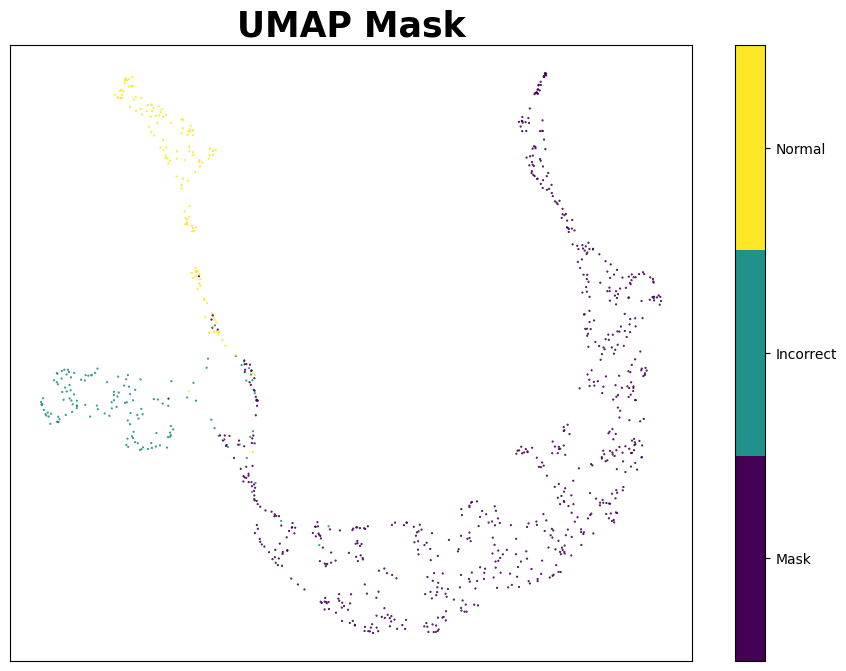

In [32]:
fig, ax = plt.subplots(figsize=(11, 8), constrained_layout=False)
ax.set(xticks=[], yticks=[])

umap_embedding_mask = UMAP(
    n_neighbors=umap_hparams["n_neighbors"],
    min_dist=umap_hparams["min_dist"],
    n_components=umap_hparams["n_components"],
    metric=umap_hparams["metric"],
).fit_transform(embedding_mask.detach().cpu().numpy())
scatter = ax.scatter(
    x=umap_embedding_mask[:, 0], y=umap_embedding_mask[:, 1], s=0.3, c=mask_label.cpu(),
)

cbar = plt.colorbar(scatter, boundaries=np.arange(4) - 0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(["Mask", "Incorrect", "Normal"])

plt.title("UMAP Mask", fontsize=25, fontweight="bold")
plt.show()

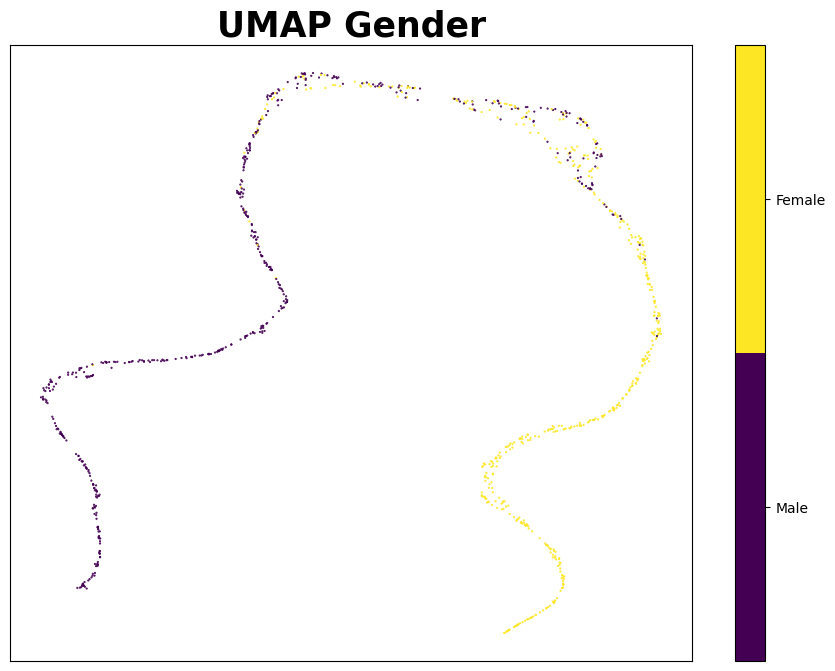

In [33]:
fig, ax = plt.subplots(figsize=(11, 8), constrained_layout=False)
ax.set(xticks=[], yticks=[])

umap_embedding_gender = UMAP(
    n_neighbors=umap_hparams["n_neighbors"],
    min_dist=umap_hparams["min_dist"],
    n_components=umap_hparams["n_components"],
    metric=umap_hparams["metric"],
).fit_transform(embedding_gender.detach().cpu().numpy())
scatter = ax.scatter(
    x=umap_embedding_gender[:, 0], y=umap_embedding_gender[:, 1], s=0.3, c=gender_label.cpu(),
)

cbar = plt.colorbar(scatter, boundaries=np.arange(3) - 0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(["Male", "Female"])

plt.title("UMAP Gender", fontsize=25, fontweight="bold")
plt.show()

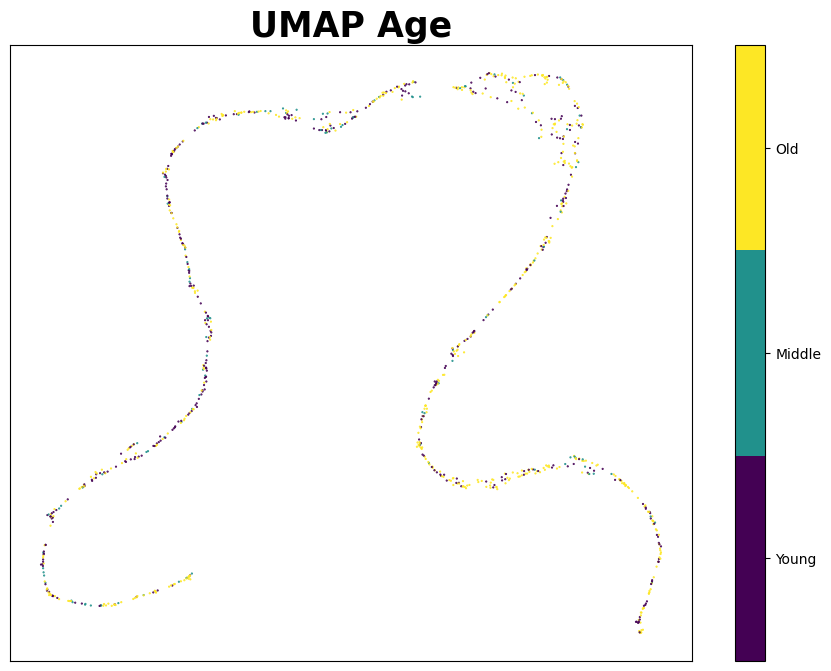

In [34]:
fig, ax = plt.subplots(figsize=(11, 8), constrained_layout=False)
ax.set(xticks=[], yticks=[])

umap_embedding_age = UMAP(
    n_neighbors=umap_hparams["n_neighbors"],
    min_dist=umap_hparams["min_dist"],
    n_components=umap_hparams["n_components"],
    metric=umap_hparams["metric"],
).fit_transform(embedding_gender.detach().cpu().numpy())
scatter = ax.scatter(
    x=umap_embedding_age[:, 0], y=umap_embedding_age[:, 1], s=0.3, c=age_label.cpu(),
)

cbar = plt.colorbar(scatter, boundaries=np.arange(4) - 0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(["Young", "Middle", "Old"])

plt.title("UMAP Age", fontsize=25, fontweight="bold")
plt.show()

In [37]:
umap_hparams = {"n_neighbors": 5, "min_dist": 0.1, "n_components": 2, "metric": "euclidean"}


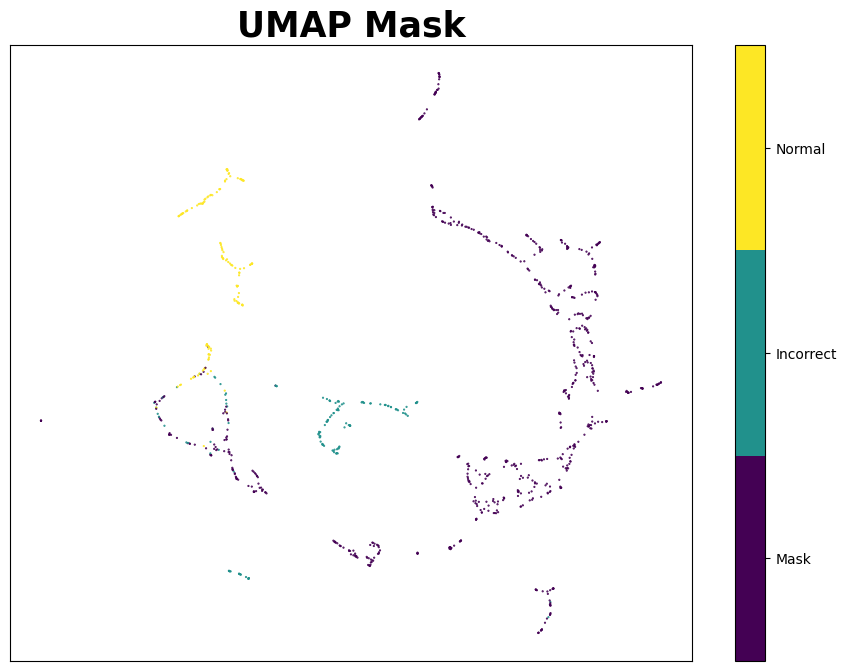

In [38]:

fig, ax = plt.subplots(figsize=(11, 8), constrained_layout=False)
ax.set(xticks=[], yticks=[])

umap_embedding_mask = UMAP(
    n_neighbors=umap_hparams["n_neighbors"],
    min_dist=umap_hparams["min_dist"],
    n_components=umap_hparams["n_components"],
    metric=umap_hparams["metric"],
).fit_transform(embedding_mask.detach().cpu().numpy())
scatter = ax.scatter(
    x=umap_embedding_mask[:, 0],
    y=umap_embedding_mask[:, 1],
    s=0.3,
    c=mask_label.cpu(),
)

cbar = plt.colorbar(scatter, boundaries=np.arange(4) - 0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(["Mask", "Incorrect", "Normal"])

plt.title("UMAP Mask", fontsize=25, fontweight="bold")
plt.show()

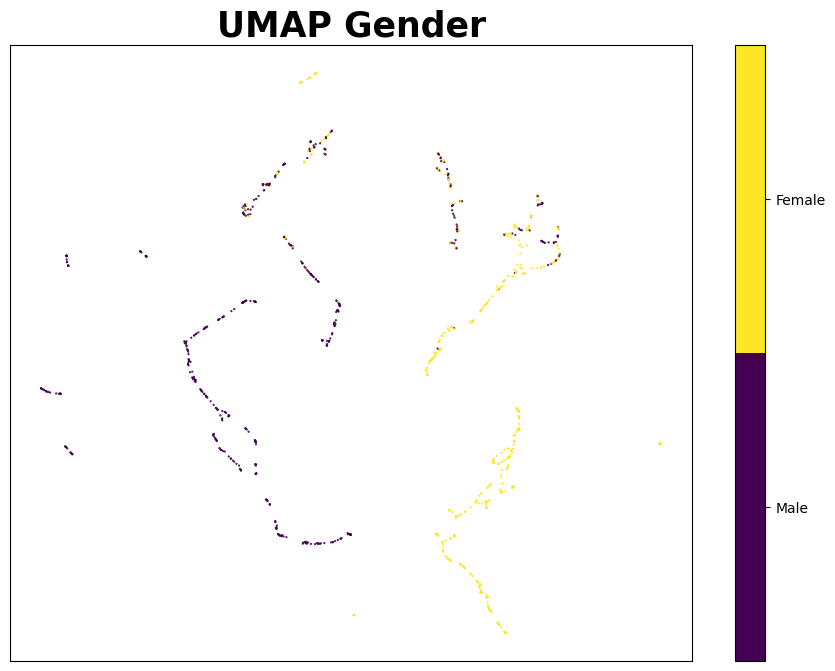

In [39]:
fig, ax = plt.subplots(figsize=(11, 8), constrained_layout=False)
ax.set(xticks=[], yticks=[])

umap_embedding_gender = UMAP(
    n_neighbors=umap_hparams["n_neighbors"],
    min_dist=umap_hparams["min_dist"],
    n_components=umap_hparams["n_components"],
    metric=umap_hparams["metric"],
).fit_transform(embedding_gender.detach().cpu().numpy())
scatter = ax.scatter(
    x=umap_embedding_gender[:, 0],
    y=umap_embedding_gender[:, 1],
    s=0.3,
    c=gender_label.cpu(),
)

cbar = plt.colorbar(scatter, boundaries=np.arange(3) - 0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(["Male", "Female"])

plt.title("UMAP Gender", fontsize=25, fontweight="bold")
plt.show()

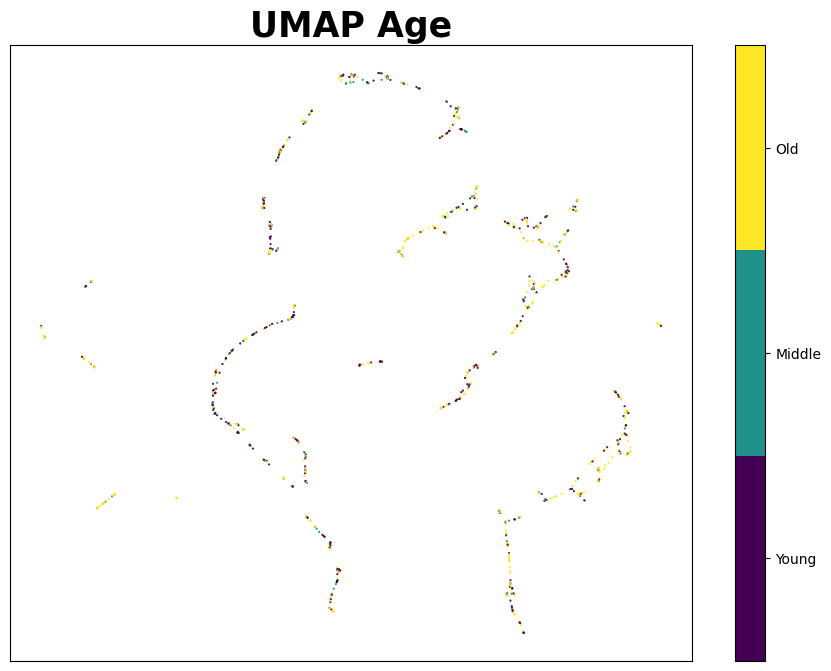

In [40]:
fig, ax = plt.subplots(figsize=(11, 8), constrained_layout=False)
ax.set(xticks=[], yticks=[])

umap_embedding_age = UMAP(
    n_neighbors=umap_hparams["n_neighbors"],
    min_dist=umap_hparams["min_dist"],
    n_components=umap_hparams["n_components"],
    metric=umap_hparams["metric"],
).fit_transform(embedding_gender.detach().cpu().numpy())
scatter = ax.scatter(
    x=umap_embedding_age[:, 0],
    y=umap_embedding_age[:, 1],
    s=0.3,
    c=age_label.cpu(),
)

cbar = plt.colorbar(scatter, boundaries=np.arange(4) - 0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(["Young", "Middle", "Old"])

plt.title("UMAP Age", fontsize=25, fontweight="bold")
plt.show()